In [9]:
!pip3 install PyTDC rdkit tensorflow mordred pandas scikit-learn numpy matplotlib xgboost



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tdc.single_pred import ADME

In [5]:
from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split = data.get_split()
data = data.get_data()


Found local copy...
Loading...
Done!


In [6]:
def mol_to_fp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits, dtype=int)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [7]:
X = np.array([mol_to_fp(i) for i in data['Drug']])
y = np.array(data['Y'])
print(X.shape, y.shape)

[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:39] WARNING: not removing hydrogen atom without neighbors
[17:52:40] WARNING: not removing hydrogen atom without neighbors
[17:52:40] WARNING: not removing hydrogen atom without neighbors
[17:52:40] WARNING: not removing hydrogen atom without neighbors
[17:52:40] WARNING: not removing hydrogen atom without neighbors
[17:52:40] WARNING: not r

(9982, 1024) (9982,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Can add more models if you want but I've already found this to be the best (and pretty fast)

models = {
    "XGBRegressor": {
        "model": XGBRegressor(random_state=33),
        "param_grid": {
            'n_estimators': [100, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1],
        },
    },
}

best_models = {}
best_scores = {}
best_params = {}

for model_name, mp in models.items():
    print(f"=== Grid Search for {model_name} ===")
    grid_search = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["param_grid"],
        scoring='neg_mean_squared_error',  
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    
    best_estimator = grid_search.best_estimator_
    cv_mse = -grid_search.best_score_  

    # Evaluate on the test set
    y_pred_test = best_estimator.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)

    print("Best Parameters:", grid_search.best_params_)
    print("CV MSE:", cv_mse)
    print("Test RMSE:", test_rmse)
    print("")

    
    best_models[model_name] = best_estimator
    best_scores[model_name] = test_mse
    best_params[model_name] = grid_search.best_params_


best_model_name = min(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print(f"Best overall model: {best_model_name}")
print(f"Parameters: {best_params[best_model_name]}")
print(f"Test MSE: {best_scores[best_model_name]}")



=== Grid Search for XGBRegressor ===
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
CV MSE: 1.9030248921130073
Test RMSE: 1.2857622113154235

Best overall model: XGBRegressor
Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
Test MSE: 1.6531844640467275


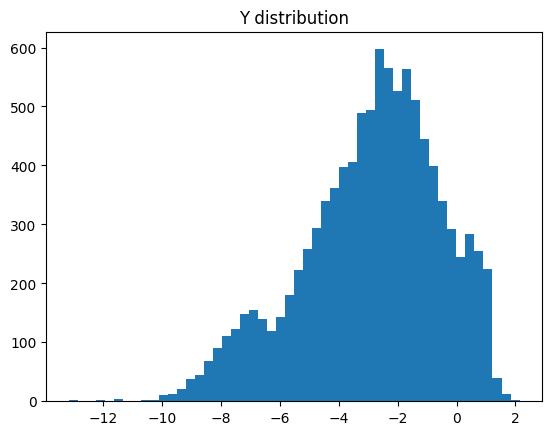

In [11]:
# plot Y distribution
plt.hist(y, bins=50)
plt.title("Y distribution")
plt.show()


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Test MSE:", mse_test)
print("Test MAE:", mae_test)
print("Test R^2:", r2_test)

Test MSE: 1.6531844640467275
Test MAE: 0.9364123160521413
Test R^2: 0.6952456106213676


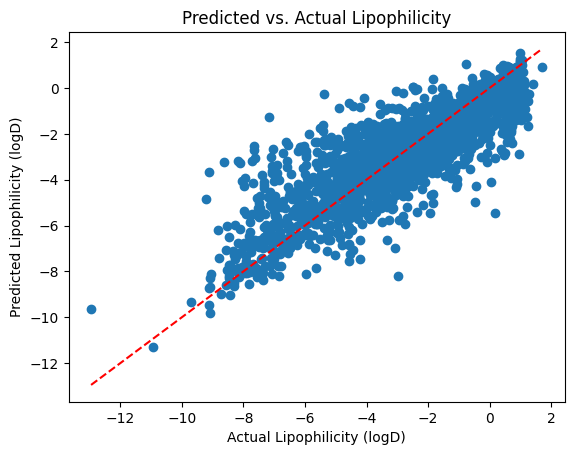

In [13]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_pred)
plt.xlabel("Actual Solubility (logS)")
plt.ylabel("Predicted Solubility (logS)")
plt.title("Predicted vs. Actual Solubility")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()

In [14]:
test_smiles = "CC(=O)Nc1ccc(cc1)O" 
test_smiles = mol_to_fp(test_smiles)

best_model.predict([test_smiles])

array([-1.8039013], dtype=float32)